# Figures pour le papier Digital Twins

In [1]:
from snake_ai.envs import RandomObstaclesEnv
from snake_ai.envs.geometry import Rectangle
import snake_ai.utils.visualization as vis

import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as splinalg
import tqdm

pygame 2.4.0 (SDL 2.26.5, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.11


[I 05/31/24 15:11:27.624 28679] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Définition des différences finies

In [2]:
def create_laplacian_matrix_2d(
    nx: int, ny: int, dx: float, dy: float
) -> sp.lil_array:
    Dxx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dyy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    return sp.kronsum(Dyy, Dxx, format="csr")


def create_laplacian_matrix_3d(
    nx: int, ny: int, nz: int, dx: float, dy: float, dz: float
) -> sp.lil_array:
    # Compute the 2D laplacian matrix
    laplace_2d = create_laplacian_matrix_2d(nx, ny, dx, dy)

    Dzz = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nz, nz)) / dz**2
    return sp.kronsum(Dzz, laplace_2d, format="csr")

In [3]:
# Definition of functions to convert between indices and subscripts
def ind2sub_2D(array_shape, ind):
    rows = (ind / array_shape[1])
    cols = ind % array_shape[1]
    return np.array([rows, cols], dtype='int')

def sub2ind_2D(array_shape, rows, cols):
    return int(rows*array_shape[1] + cols)

In [4]:
def apply_dirichlet_2D(A: sp.spmatrix, binary_map: np.ndarray):
    """Apply the Dirichlet boundary conditions to the linear system.

    Args:
        A (sp.spmatrix): Sparse matrix of the linear system Ax = b
        binary_map (np.ndarray): binary map of the domain, where 1 correspond to spaces to apply the boundary conditions 
    """
    res = binary_map.shape
    max_index = np.prod(res)
    rhs = np.zeros(max_index)
    assert A.shape == (max_index, max_index), "Shape mismatch between the matrix and the binary map"  

    rows, cols = np.nonzero(binary_map)   
    for i, j in tqdm.tqdm(zip(rows, cols), total=len(rows)):
        index = sub2ind_2D(res, i, j)
        
        A[index, index] = 1
        rhs[index] = binary_map[i, j]
        
        ind_o = sub2ind_2D(res, i + 1, j)
        ind_e = sub2ind_2D(res, i - 1, j)
        ind_n = sub2ind_2D(res, i, j + 1)
        ind_s = sub2ind_2D(res, i, j - 1)
        
        for neighbour_ind in [ind_o, ind_e, ind_n, ind_s]:
            # Set the row to the identity vector and apply the colums to rhs
            if neighbour_ind >= 0 and neighbour_ind < max_index:
                A[index, neighbour_ind] = 0
                rhs[neighbour_ind] -= A[neighbour_ind, index] * rhs[index]
                A[neighbour_ind, index] = 0
    return A, rhs

# Definition d'environement à partir de carte binaires 

In [5]:
binary_map = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])
binary_map.shape

obstacles = [Rectangle(x, y, 1, 1) for x, y in zip(*np.where(binary_map == 1))]


In [6]:
res = 20
x_max, y_max = binary_map.shape

new_obs_map = np.zeros((x_max * res, y_max * res))
for x, y in np.argwhere(binary_map):
    new_obs_map[x*res:(x+1)*res, y*res:(y+1)*res] = 1

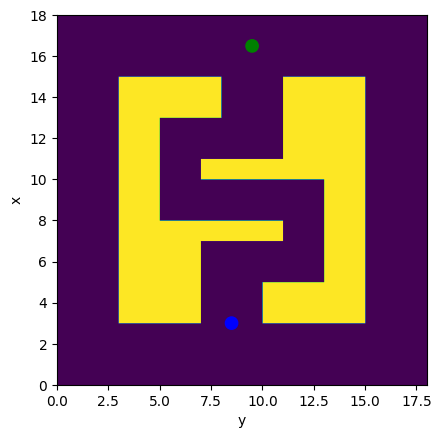

In [7]:
init_pos = np.array([3.0, 8.5])
goal_pos = np.array([16.5, 9.5])
fig, ax = plt.subplots()
ax.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])
ax.set(xlabel='y', ylabel='x')
ax.add_patch(plt.Circle(init_pos[::-1], 0.3, color="blue"))
ax.add_patch(plt.Circle(goal_pos[::-1], 0.3, color="green"))   

100%|██████████| 1/1 [00:00<00:00, 596.97it/s]


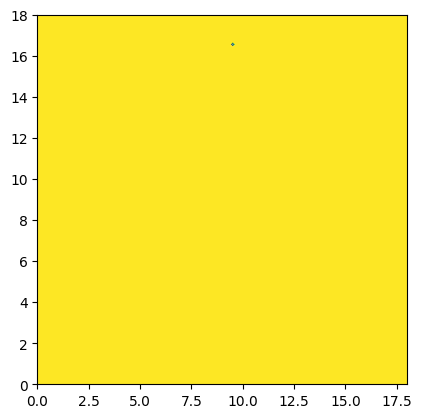

In [8]:
## 
step = np.array(binary_map.shape) / np.array(new_obs_map.shape)
laplace = create_laplacian_matrix_2d(*new_obs_map.shape, *step)
rhs = np.zeros(new_obs_map.shape)
goal_ind = np.array(goal_pos * res, dtype=int)
rhs[goal_ind[0], goal_ind[1]] = 1e3
laplace, rhs = apply_dirichlet_2D(laplace, rhs)
plt.imshow(rhs.reshape(new_obs_map.shape), origin='lower', extent=[0, x_max, 0, y_max])
# plt.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])

In [9]:
valid_ind = new_obs_map.flat == 0
A = laplace[valid_ind][:, valid_ind]
b = rhs.flat[valid_ind]
x = splinalg.spsolve(A, b)
solution = np.zeros(new_obs_map.shape, dtype=float)
solution.flat[valid_ind] = x

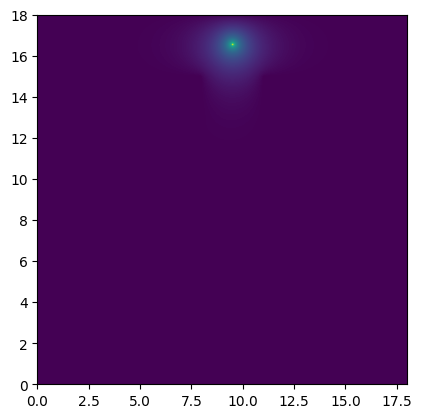

In [10]:
plt.imshow(solution, origin='lower', extent=[0, x_max, 0, y_max])


## Now let's run differentiable simulations
Here we want to run a simulation with bending constraints.

In [11]:
import taichi as ti
import taichi.math as tm
from  snake_ai.diffsim.walk_simulation import WalkerSimulationStoch2D
from snake_ai.diffsim.field import ScalarField
from typing import List

@ti.data_oriented
class BendingSimulation(WalkerSimulationStoch2D):
    def __init__(self, positions: np.ndarray, potential_field: ScalarField, obstacles: List[Rectangle] = None, t_max: float = 100, dt: float = 0.1, diffusivity: float = 1):
        super().__init__(positions, potential_field, obstacles, t_max, dt, diffusivity) 
        self.distance_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.bending_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.total_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)

    @ti.kernel
    def reset(self):
        for n in ti.ndrange(self.nb_walkers):
            self.states[n, 0].pos = self._init_pos[n]
            self.states[n, 0].vel = tm.vec2(0.0, 0.0)
            for t in ti.ndrange(self.nb_steps):
                self._noise[n, t] = tm.vec2(ti.randn(), ti.randn())
        for i, j in self.force_field._values:
            self.force_field._values.grad[i, j] = tm.vec2(0.0, 0.0)
        self.distance_loss[None] = 0.0
        self.bending_loss[None] = 0.0
        self.total_loss[None] = 0.0

    
    @ti.kernel
    def compute_distance_loss(self, target : ti.template(), t : int):
        for n in range(self.nb_walkers):
            ti.atomic_add(self.distance_loss[None], tm.length(self.states[n, t].pos - target)**2)
    
    @ti.kernel
    def compute_bending_loss(self):
        for n in range(self.nb_walkers):
            for t in range(self.nb_steps - 1):
                F_t1 = self.force_field._at_2d(self.states.pos[n, t])
                F_t2 = self.force_field._at_2d(self.states.pos[n, t + 1])
                bending = tm.atan2(tm.cross(F_t1, F_t2), tm.dot(F_t1, F_t2))
                ti.atomic_add(self.bending_loss[None], bending ** 2)
                
    @ti.kernel
    def compute_total_loss(self, distance : float, bending : float):
        self.total_loss[None] = distance * self.distance_loss[None] + bending * self.bending_loss[None]

In [12]:
ti.init(arch=ti.gpu)

nb_agents = 20
t_max = 100
dt = 0.1
diffusivity = 0.1

positions = np.repeat(init_pos.reshape(1, 2), nb_agents, axis=0)
field = ScalarField(solution, Rectangle(0, 0, x_max, y_max))
bending_sim = BendingSimulation(positions, field, t_max=t_max, dt=dt, diffusivity=diffusivity, obstacles=obstacles)
bending_sim.reset()
bending_sim.run(diffusivity)
bending_sim.compute_bending_loss()
bending_sim.compute_distance_loss(tm.vec2(goal_pos), t_max - 1)
bending_sim.compute_total_loss(1, 1)

print(f"bending : {bending_sim.bending_loss[None]}, distance : {bending_sim.distance_loss[None]}, total : {bending_sim.total_loss[None]}")

[Taichi] Starting on arch=cuda
bending : 23264.802734375, distance : 3533.95947265625, total : 26798.76171875


(0.0, 18.0)

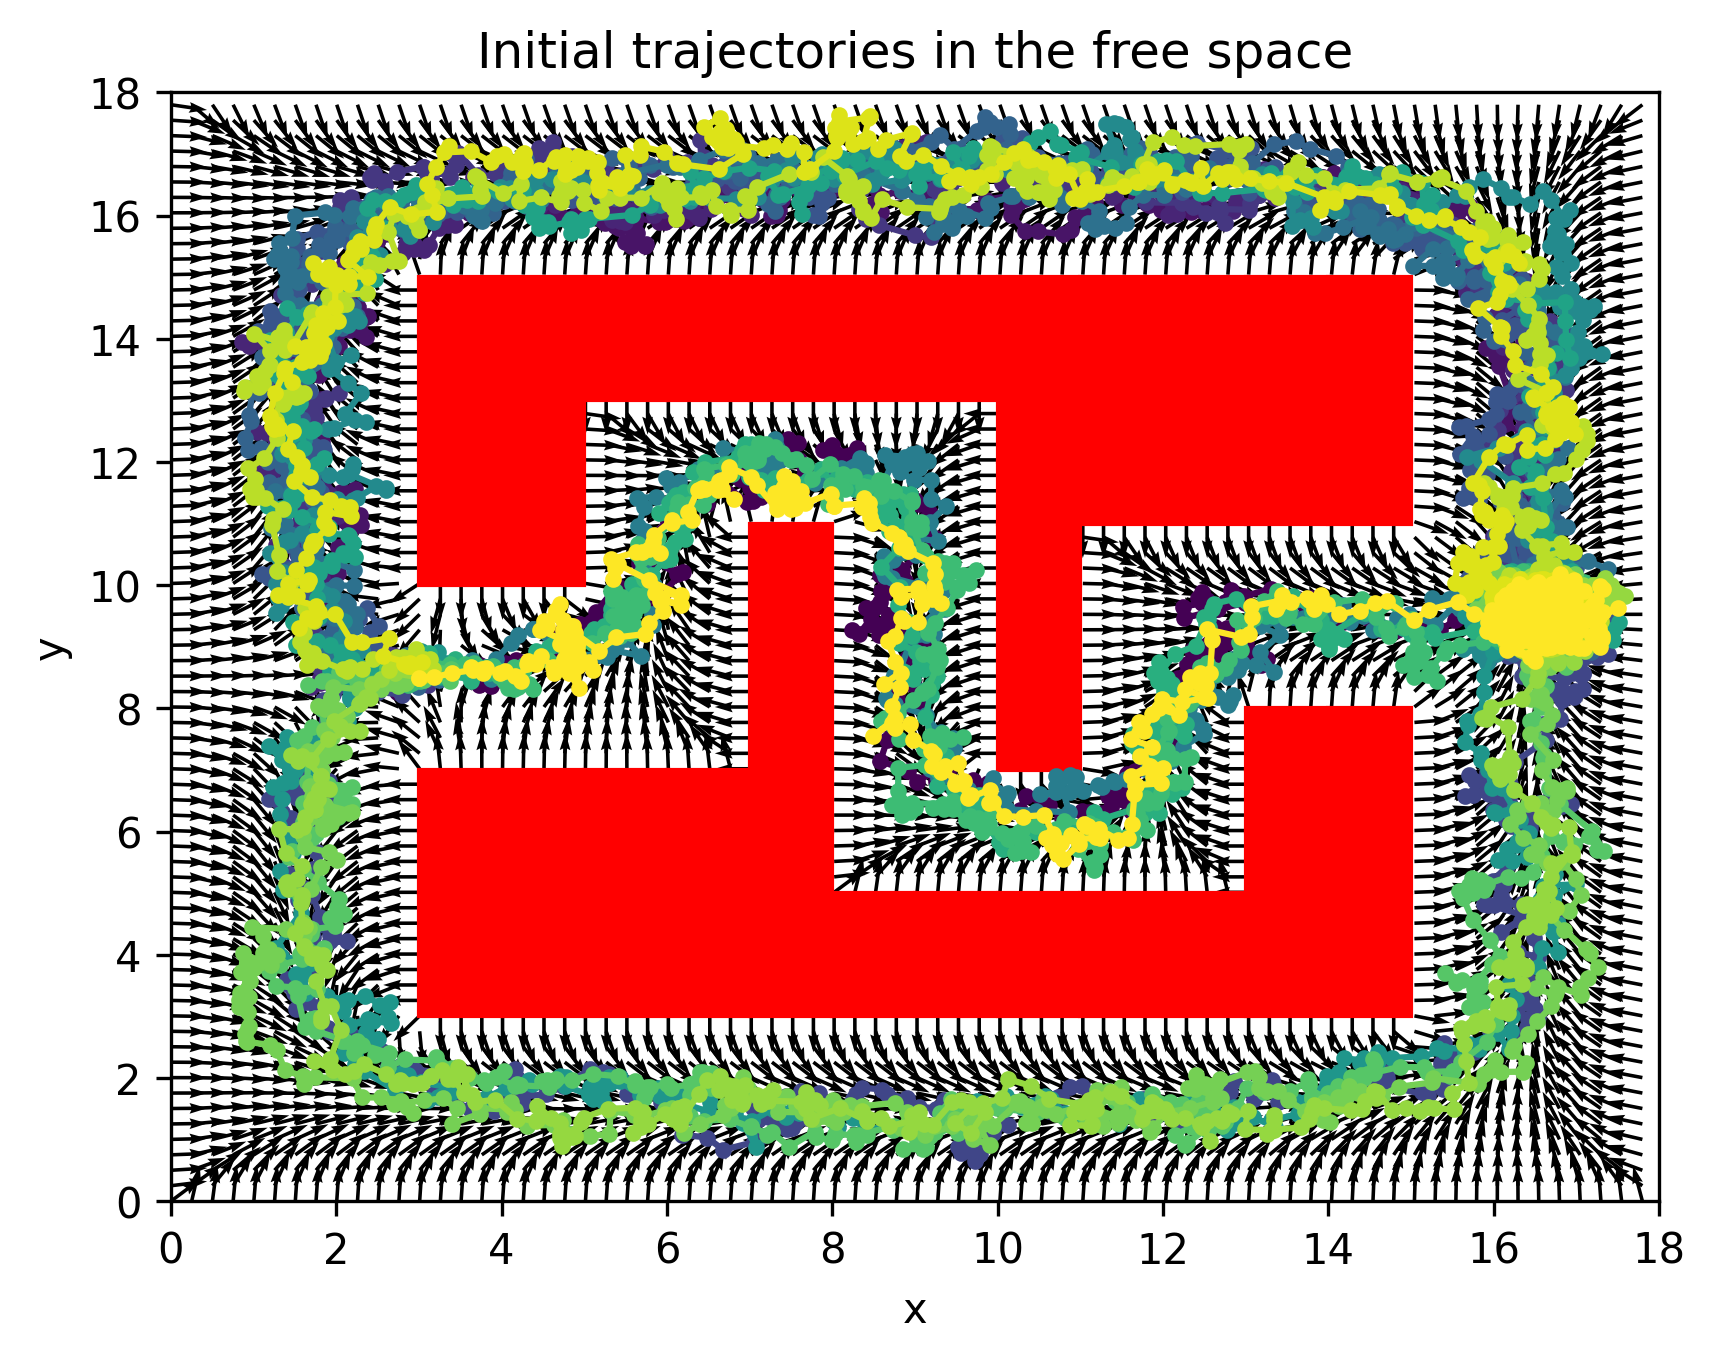

In [13]:
downscale = 5
scale = 2
# Visualisation
fig = vis.plot_2D_trajectory(bending_sim.positions, 
                             goal_pos, 
                             obstacles=obstacles, 
                             vector_field=bending_sim.force_field, 
                             downscale=downscale, 
                             scale = scale, 
                             title="Initial trajectories in the free space")
plt.xlim(0, x_max)
plt.ylim(0, y_max)

We can now try to optimize the force field to limit bending

In [14]:
max_iter = 100
lr = 0.01
clip = 0.
diffusivity=0.1
# diffusivities = np.linspace(1, 0.1, max_iter)

w_distance, w_bend = 1.0, 1.0

best_loss = np.inf
best_vector_field = None

target = tm.vec2(goal_pos)
for iter in range(max_iter):
    bending_sim.reset()
    with ti.ad.Tape(bending_sim.total_loss):
        bending_sim.run(diffusivity=diffusivity)
        # bending_sim.run(diffusivity=diffusivities[iter])
        bending_sim.compute_distance_loss(target, bending_sim.nb_steps - 1)
        bending_sim.compute_bending_loss()
        bending_sim.compute_total_loss(w_distance, w_bend)
    # if bending_sim.total_loss[None] < best_loss:
    #     best_loss = bending_sim.total_loss[None]
    #     best_vector_field = np.copy(bending_sim.force_field._values.to_numpy())
    print("Iter=", iter, "Loss=", bending_sim.total_loss[None], "Distance=", bending_sim.distance_loss[None], "Bending=", bending_sim.bending_loss[None])
    if clip > 0:
        bending_sim.clip_force_field(clip)
    bending_sim._update_force_field(lr)

[E 05/31/24 15:12:42.810 28679] [cuda_driver.h:operator()@92] CUDA Error CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered while calling malloc_async_impl (cuMemAllocAsync)


RuntimeError: [cuda_driver.h:operator()@92] CUDA Error CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered while calling malloc_async_impl (cuMemAllocAsync)

(0.0, 18.0)

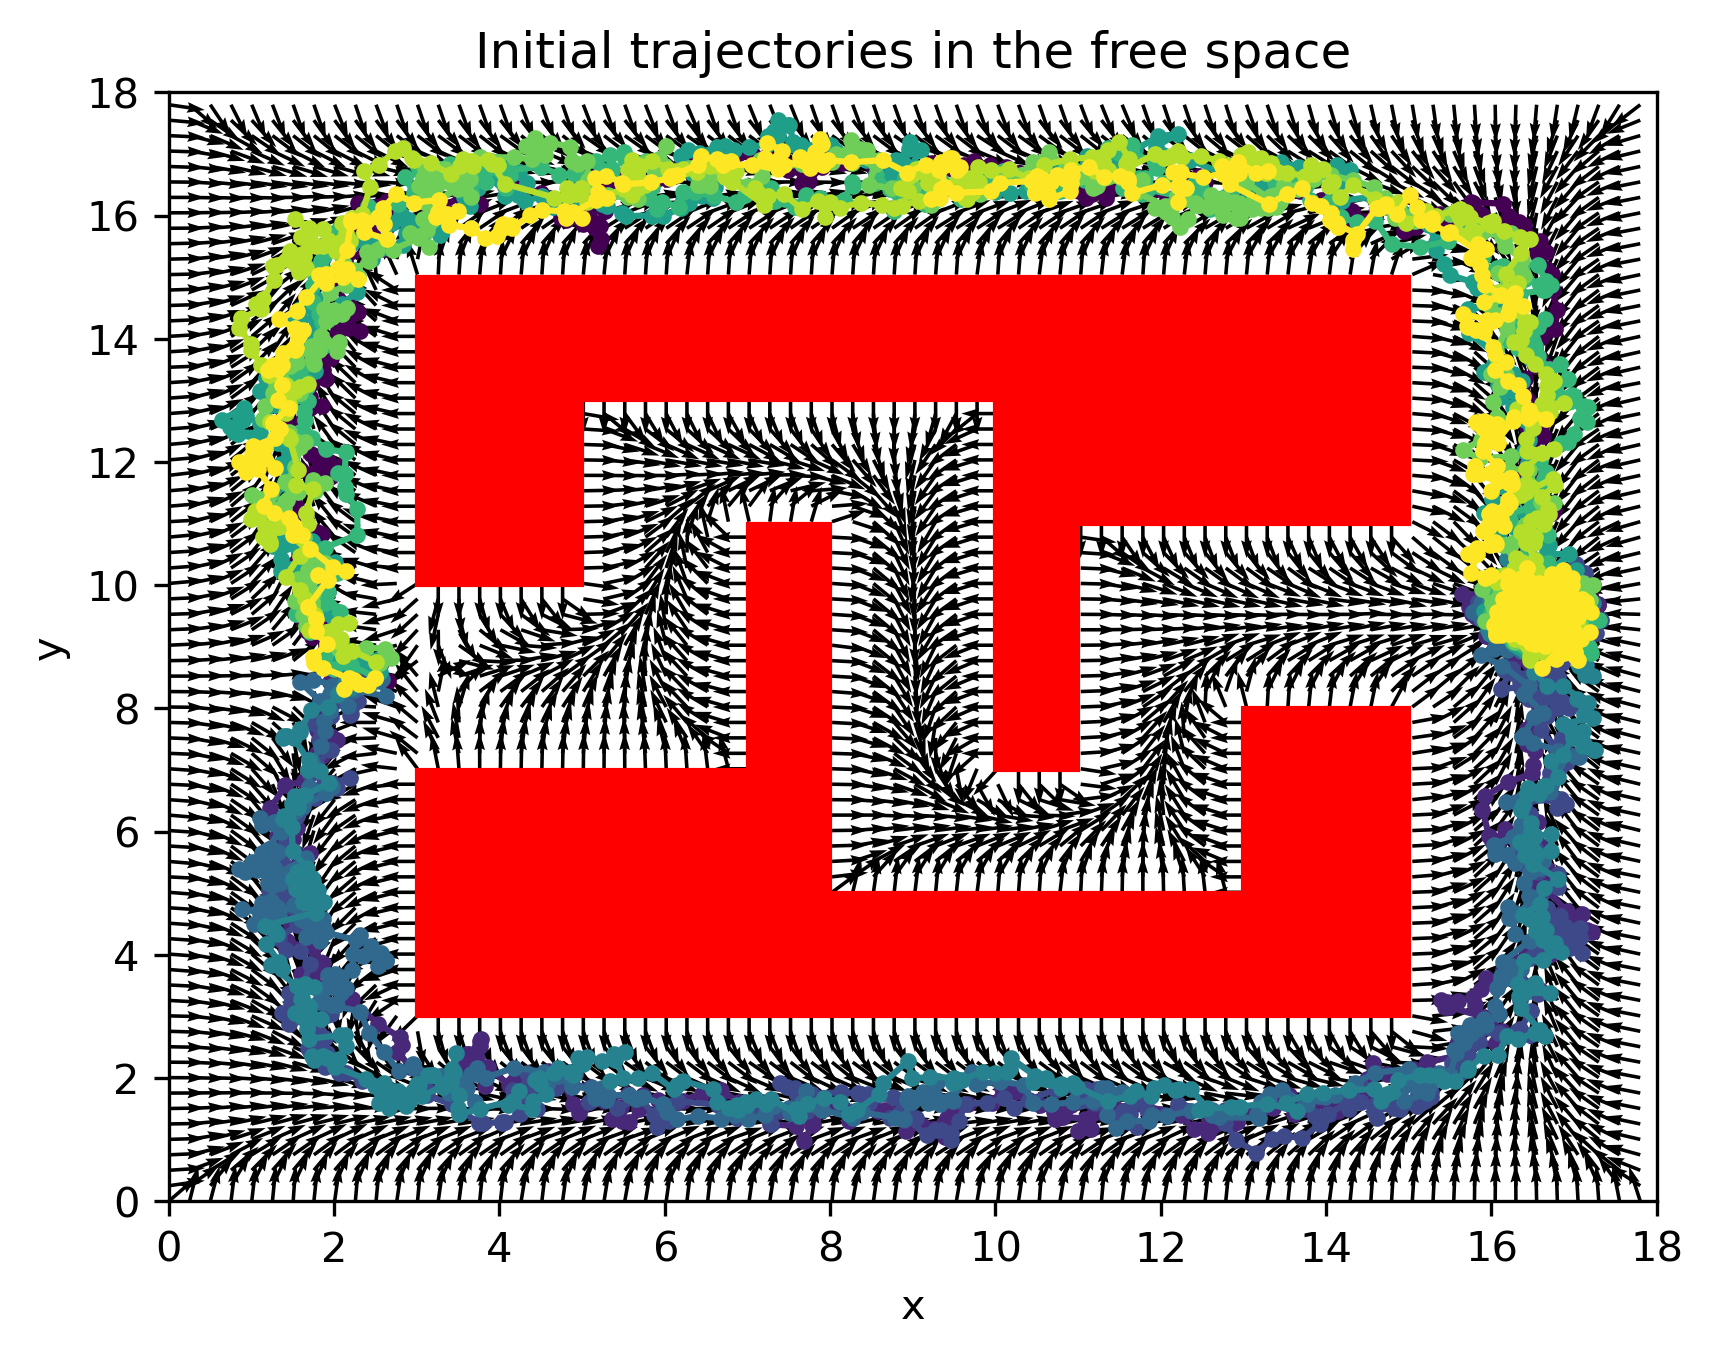

In [19]:
downscale = 5
scale = 2
# Visualisation
fig = vis.plot_2D_trajectory(bending_sim.positions, 
                             goal_pos, 
                             obstacles=obstacles, 
                             vector_field=bending_sim.force_field, 
                             downscale=downscale, 
                             scale = scale, 
                             title="Initial trajectories in the free space")
plt.xlim(0, x_max)
plt.ylim(0, y_max)